In [1]:
from random import randint
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score , roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, Input
from tensorflow.keras.layers import Flatten, MaxPool2D, AvgPool2D
from tensorflow.keras.layers import BatchNormalization, Reshape, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model, load_model

from PIL import Image

seed = 123

## Tratamento, balanceamento e split de treino e teste de descritivos

In [2]:
# Caminhos dos  csvs:
treino_2018 ="/media/leandro/84EE-B5FB/isic_2018_treino.csv"
treino_2017 ="/media/leandro/84EE-B5FB/isic_2017_treino.csv"
teste = "/media/leandro/84EE-B5FB/isic_2017_teste.csv"
validacao = "/media/leandro/84EE-B5FB/isic_2017_validacao.csv"


In [3]:
# primeiramente, abrimos os descritivos dos dados de treino, a fim de analisar o balanceamento dos dados;
# julgamos válido ajustar a rede a um conjunto de dados balanceado, assim, evitando enviesar a rede

df_treino_2017 = pd.read_csv(treino_2017)
df_treino_2018 = pd.read_csv(treino_2018)

In [4]:
# analisando descritivo de treino de 2017
df_treino_2017.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0


In [5]:
# ------- TREINO 2017

df_treino_2017['image_id'] = df_treino_2017['image_id'].apply(lambda x: x + '.jpg')
df_treino_2017['nevus'] = ((df_treino_2017['melanoma'] == 0) & 
                           (df_treino_2017['seborrheic_keratosis'] == 0)).astype(float)
df_treino_2017.drop('seborrheic_keratosis', axis = 1, inplace = True)
df_treino_2017 = df_treino_2017.loc[(df_treino_2017['melanoma'] == 1) | (df_treino_2017['nevus'] == 1)]

# nesta célula, adicionamos extensões aos nomes dos arquivos, para que estes correspondam exatamente aos nomes
# que de fato seriam usados para acessar as imagens, por código, em seguida, precisávamos saber quais imagens
# eram casos de 'nevus', como esta flag não existe, inferimos que casos que não fossem 'melanoma', nem 
# 'seborrheic_keratosis' seriam 'nevus', à partir disso, criamos uma terceira flag, eliminamos a flag
# 'seborrheic_keratosis', que não nos convinha, por fim, mantivemos no dataframe, apenas as imagens
# que representassem ou casos de 'nevus' ou 'melanoma'

In [6]:
df_treino_2017.head()

,image_id,melanoma,nevus
0,ISIC_0000000.jpg,0.0,1.0
1,ISIC_0000001.jpg,0.0,1.0
2,ISIC_0000002.jpg,1.0,0.0
3,ISIC_0000003.jpg,0.0,1.0
4,ISIC_0000004.jpg,1.0,0.0


In [7]:
# partimos para o descritivo de treino de 2018

df_treino_2018.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# ------- TREINO 2018

df_treino_2018['image'] = df_treino_2018['image'].apply(lambda x: x + '.jpg')
df_treino_2018 = df_treino_2018.loc[(df_treino_2018['MEL'] == 1) | (df_treino_2018['NV'] == 1)]
df_treino_2018 = df_treino_2018[['image', 'MEL', 'NV']]
# nesta célula, apenas adicinamos as extensões aos nomes dos arquivos, filtramos imagens que representassem 
# casos de 'nevus' ou 'melanoma', por meio das flags 'NEV' e 'ML'

In [9]:
df_treino_2018.head()

,image,MEL,NV
0,ISIC_0024306.jpg,0.0,1.0
1,ISIC_0024307.jpg,0.0,1.0
2,ISIC_0024308.jpg,0.0,1.0
3,ISIC_0024309.jpg,0.0,1.0
4,ISIC_0024310.jpg,1.0,0.0


In [10]:
# aqui, unificamos os nomes das series dos descritivos, para que possam ser concatenados
df_treino_2018.columns = ['img', 'pos', 'neg']
df_treino_2017.columns = ['img', 'pos', 'neg']

In [11]:
# como podemos ver abaixo, as bases estão desbalanceadas

In [12]:
df_treino_2017['pos'].value_counts(1)

0.0    0.785796
1.0    0.214204
Name: pos, dtype: float64

In [13]:
df_treino_2018['pos'].value_counts(1)

0.0    0.857636
1.0    0.142364
Name: pos, dtype: float64

In [14]:
# nesta célula, juntamos as duas bases, como o intuito de obter um conjunto balanceado de dados

# separando casos positivos e negativos de cada ano
pos_2018 = df_treino_2018.loc[df_treino_2018['pos'] == 1]
pos_2017 = df_treino_2017.loc[df_treino_2017['pos'] == 1]

neg_2018 = df_treino_2018.loc[df_treino_2018['neg'] == 1]
neg_2017 = df_treino_2017.loc[df_treino_2017['neg'] == 1]

# juntando casos positivos e negativos de todos os anos
full_pos = pd.concat([pos_2017, pos_2018], axis = 0)
full_neg = pd.concat([neg_2017, neg_2018], axis = 0)

# amostrando aleatoriamente, n dados negativos, estes consistirão nas observações negativas (a amostragem
# é feita para separar um número de imagens equivalente ao número de imagens positivas que temos à disposição)
full_neg = full_neg.sample(n = full_pos.shape[0], random_state = seed)

full_pos = full_pos[['img', 'pos', 'neg']]
full_neg = full_neg[['img', 'pos', 'neg']]

filenames = pd.concat([full_pos, full_neg]).reset_index().drop('index', axis = 1)

filenames['pos'].value_counts()

0.0    1487
1.0    1487
Name: pos, dtype: int64

In [15]:
# com base no conjunto balanceado, obtemos splits de treino e teste
df_treino, df_teste = train_test_split(filenames, test_size = 0.2, random_state = seed)

In [16]:
# analisamos aqui, o descritivo de validação

df_valid = pd.read_csv(validacao)

In [17]:
df_valid.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0


In [18]:
df_valid['image_id'] = df_valid['image_id'].apply(lambda x: x + '.jpg')
df_valid['nevus'] = ((df_valid['melanoma'] == 0) & 
                           (df_valid['seborrheic_keratosis'] == 0)).astype(float)
df_valid.drop('seborrheic_keratosis', axis = 1, inplace = True)
df_valid = df_valid.loc[(df_valid['melanoma'] == 1) | (df_valid['nevus'] == 1)]

df_valid.columns = ['img', 'pos', 'neg']
# para o tratamento do descritivo de validação, foi necessário adicionar extensões e criar a flag 'nevus', 
# de forma similar ao tratamento do descritivo de 2017, além disso, filtramos por apenas casos de 
# 'melanoma' ou 'nevus', também foram aplicados os mesmos nomes para as series 

In [19]:
df_valid.head()

,img,pos,neg
0,ISIC_0001769.jpg,0.0,1.0
1,ISIC_0001852.jpg,0.0,1.0
2,ISIC_0001871.jpg,0.0,1.0
3,ISIC_0003462.jpg,0.0,1.0
4,ISIC_0003539.jpg,0.0,1.0


In [20]:
# como podemos observar, a base de validação está desbalanceada

df_valid['pos'].value_counts(1)

0.0    0.722222
1.0    0.277778
Name: pos, dtype: float64

In [21]:
# para balanceá-la, elminaremos casos negativos o suficiente para que o número resultante se equipare 
# ao número de casos positivos

df_valid_pos = df_valid.loc[df_valid['pos'] == 1]
df_valid_neg = df_valid.loc[df_valid['neg'] == 1]

In [22]:
len(df_valid_pos), len(df_valid_neg)

# amostraremos 30 valores aleatórios dentre os casos negativos, e estes serão concatenados ao conjunto de
# casos positivos, o conjunto resultante consistirá no descritivo de validação

(30, 78)

In [23]:
df_valid_neg = df_valid_neg.sample(30, random_state = seed)
df_valid = pd.concat([df_valid_pos, df_valid_neg])

In [24]:
df_valid['pos'].value_counts(1)

0.0    0.5
1.0    0.5
Name: pos, dtype: float64

In [25]:
# descritivo de teste (cujas predições devemos entregar)

df_pred = pd.read_csv(teste)

In [26]:
df_pred.head()

,image_id
0,ISIC_0012086
1,ISIC_0012092
2,ISIC_0012095
3,ISIC_0012134
4,ISIC_0012136


In [27]:
df_pred['image_id'] = df_pred['image_id'].apply(lambda x: x + '.jpg')
df_pred.columns = ['img']

# para o tratamento do descritivo de teste, aplicamos extensões e unificamos nome da series

In [28]:
df_pred.head()

,img
0,ISIC_0012086.jpg
1,ISIC_0012092.jpg
2,ISIC_0012095.jpg
3,ISIC_0012134.jpg
4,ISIC_0012136.jpg


In [29]:
# ao final do processo, possuímos df_treino, df_teste, df_valid, df_pred

In [30]:
df_treino = df_treino.reset_index()
df_valid = df_valid.reset_index()
df_treino.drop('index', axis = 1, inplace = True)
df_valid.drop('index', axis = 1, inplace = True)

## Pré-processamento

In [31]:
# farei o pré processamento das imagens conforme estiver alimentando o ajuste da rede, este será realizado em 
# batches

In [32]:
# divisão dos dados de treino em batches

n_batches = 5
data = df_treino
batch_list = []

resto = data.shape[0] % n_batches
step = data.shape[0] // n_batches
count = 0
lower_idx = 0

for n in range(n_batches):
    
    upper_idx = lower_idx + step 
    
    exec(f'batch_{count} = data.iloc[{lower_idx}:{upper_idx}]')
    exec(f'batch_list.append(batch_{count})')
    
    count += 1
    lower_idx += step
    
# somando resto ao último batch
batch_list[-1] = pd.concat([batch_list[-1], df_treino[-4:]])

# agora temos a lista 'batch_list', esta possui cinco dataframes, cada um deles, contendo uma porção de 
# 'df_treino', carregaremos cada batch e ajustaremos a rede a cada um deles

In [33]:
diretorio_treino = "/media/leandro/84EE-B5FB/isic_treino_selecionadas/"
diretorio_teste ="/media/leandro/84EE-B5FB/isic_2017_teste/"
diretorio_val ="/media/leandro/84EE-B5FB/isic_2017_validacao/isic_2017_validacao/"

In [34]:
# ao carregarmos cada um dos batches, pré processaremos e faremos 'data augmentation', através de:

# carregamento 
def get_images_n_labels(dataframe, path = diretorio_treino, 
                        series_name = 'img', label_name = 'pos', i = 200, j = 200):
    
    x = []
    y = []
    
    for n in range(dataframe.shape[0]):
        
        img = cv2.imread(path + dataframe[series_name].iloc[n])
        img = cv2.resize(img, (i, j))
        x.append(img)
        y.append(dataframe[label_name].iloc[n])
        
    return np.array(x), np.array(y)

# pré processamento

def segmentation(img):
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    sure_bg = cv2.dilate(opening,kernel,iterations = 3)
    res = cv2.bitwise_and(img,img,mask = sure_bg)
    
    return res

def bgr_CLAHE(img):
    
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit = 2.0,tileGridSize = (6, 6))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    return img

def img_preproc(img):
    
    img = bgr_CLAHE(segmentation(img))
    img = img / 255

    
    return img

# augmentation

def zoom(img, original_dim = [200, 200], h_slice = [5, 175], v_slice = [5, 175]):

    img = img[v_slice[0] : v_slice[1], h_slice[0] : h_slice[1]]
    img = cv2.resize(img, (original_dim[0], original_dim[1]))
    
    return img 

# horizontal shift
def h_shift(image, original_dim = [200, 200], shift = 5):
    
    T_x = shift
    T_y = 0
    
    M = np.array([[1, 0, T_x], [0, 1, T_y]], dtype = 'float32')
    img_transladada = cv2.warpAffine(image, M, (original_dim[0], original_dim[1]))
    img = img_transladada[0 : original_dim[0], shift : original_dim[1]]
    img = cv2.resize(img, (original_dim[0], original_dim[1]))
    
    return img

# vertical shift
def v_shift(image, original_dim = [200, 200], shift = 5):
    
    T_x = 0
    T_y = shift
    
    M = np.array([[1, 0, T_x], [0, 1, T_y]], dtype = 'float32')
    img_transladada = cv2.warpAffine(image, M, (original_dim[0], original_dim[1]))
    img = img_transladada[shift : original_dim[0], 0 : original_dim[1]]
    img = cv2.resize(img, (original_dim[0], original_dim[1]))
    
    return img

def rotation_90(img):

    rows, cols, chnls = img.shape
    M = cv2.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), 90, 1)
    img = cv2.warpAffine(img, M, (cols, rows))
    
    return img

def data_augmentation(x, y):
    
    augmentation_imgs = []
    augmentation_labels = []

    for n in range(len(x)):

        image = x[n]
        classe = y[n]
        augment = randint(0, 2) # booleano (33.3% de chance de aplicar augmentation)

        if augment == 1:
            process = randint(0, 5) # seleção aleatória do processo de augmentation

            if process == 0:
                image = cv2.flip(image, 0)
                augmentation_imgs.append(image) # horizontal flip
                augmentation_labels.append(classe)

            if process == 1:
                image = zoom(image)
                augmentation_imgs.append(image) # zoom 0.2
                augmentation_labels.append(classe)

            if process == 2:
                image = h_shift(image)
                augmentation_imgs.append(image) # horizontal shift
                augmentation_labels.append(classe)

            if process == 3:
                image = v_shift(image)
                augmentation_imgs.append(image) # vertical shift
                augmentation_labels.append(classe)

            if process == 4:
                image = rotation_90(image)
                augmentation_imgs.append(image) # rotaton 90°
                augmentation_labels.append(classe)
                
    return augmentation_imgs, augmentation_labels

# consolidando os processos acima em um função
def single_batch_prep(batch_df, width = 200, height = 200):
    
    x, y = get_images_n_labels(batch_df)

    # pré processamento de imagens
    x = [img_preproc(i) for i in x]

    # data augmentation
    augmentation_imgs, augmentation_labels = data_augmentation(x, y)
    
    return np.array(x + augmentation_imgs), np.array(list(y) + augmentation_labels)

In [35]:

px_h, px_v, chnls = 200, 200, 3
ipt_e = Input(shape = (px_h, px_v, chnls))

encoder = Conv2D(4, (3, 3), input_shape = (px_h, px_v, chnls), activation = 'relu', padding = 'same')(ipt_e)
encoder = MaxPool2D((5, 5))(encoder)
encoder = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(encoder)
encoder = MaxPool2D((2, 2))(encoder)
encoder = Conv2D(16, (2, 2), activation = 'relu', padding = 'same')(encoder)
encoder = Flatten()(encoder)
encoder = Dense(40, name = 'gargalo')(encoder)

decoder = Dense(6400)(encoder)
decoder = Reshape(target_shape = (20, 20, 16))(decoder)
decoder = Conv2D(8, (2, 2), activation = 'relu', padding = 'same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(4, (3, 3), activation = 'relu', padding = 'same')(decoder)
decoder = UpSampling2D((5, 5))(decoder)
decoder = Conv2D(4, (3, 3), activation = 'relu', padding = 'same')(decoder)
decoder = Conv2D(3, (3, 3), activation = 'sigmoid', padding = 'same')(decoder)

autoencoder = Model(inputs = ipt_e, outputs = decoder, name = 'autoencoder')
autoencoder.compile(loss = 'mean_squared_error')

In [36]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 4)       112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 8)         296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 16)        528       
_________________________________________________________________
flatten (Flatten)            (None, 6400)              

In [37]:
pickle.dump(batch_0, open('batch_0.pkl', 'wb'))
pickle.dump(batch_1, open('batch_1.pkl', 'wb'))
pickle.dump(batch_2, open('batch_2.pkl', 'wb'))
pickle.dump(batch_3, open('batch_3.pkl', 'wb'))
pickle.dump(batch_4, open('batch_4.pkl', 'wb'))

autoencoder.save('ae.h5')

In [38]:
x_valid, y_valid = get_images_n_labels(df_valid, path = diretorio_val)

In [39]:
# daqui para baixo, ajuste do encoder

# na função get_images_n_labels
# parametros i e j são as dimensoes,
# na função zoom, 
# original_dim é uma lista com as dimensoes, 
# h_slice e v_slice podem ser iguais, 
# são listas que devem possui dois numeros, 
# um umpouco acima do limite inferior, e outro
# pouco abaixo do limite superior, 
# na h_shift, original dim é uma lista com
# as duas dims, em v_shift, a mesma coisa, 
# na função single_batch_prep, width e height
# são os params correspondentes as dims

In [40]:
def get_batch(nn_name, batch_desc, valid_desc, valid_dir, batch_size, epochs, 
              encode = False):
    
    model = load_model(nn_name)
    batch = pickle.load(open(batch_desc, 'rb'))
    x_treino, y_treino = single_batch_prep(batch)
    
    valid = pickle.load(open(valid_desc, 'rb'))
    x_valid, y_valid = get_images_n_labels(valid, path = valid_dir)
    
    if encode == True:
        model.fit(x_treino, x_treino, batch_size = batch_size, epochs = epochs, 
                  validation_data = (x_valid, x_valid))
                  
    model.save(nn_name)

In [41]:
# get_batch('ae.h5', 'batch_0.pkl', 'df_valid.pkl', 'isic_2017_validacao/', 25, 100, encode = True)

In [42]:
# get_batch('ae.h5', 'batch_1.pkl', 'df_valid.pkl', 'isic_2017_validacao/', 25, 100, encode = True)

In [43]:
# get_batch('ae.h5', 'batch_2.pkl', 'df_valid.pkl', 'isic_2017_validacao/', 25, 100, encode = True)

In [44]:
# get_batch('ae.h5', 'batch_3.pkl', 'df_valid.pkl', 'isic_2017_validacao/', 25, 100, encode = True)

In [45]:
# get_batch('ae.h5', 'batch_4.pkl', 'df_valid.pkl', 'isic_2017_validacao/', 25, 100, encode = True)

In [46]:
# model = load_model('ae.h5')

In [47]:
# aqui, o encoder ('model') está pronto

In [48]:
# carregar batch para teste
x_0, y_0 = single_batch_prep(batch_0)

In [49]:
# neste notebook, são 5 batches ('batch_0' - 'batch_4')

In [50]:
x_treino_cod = autoencoder.predict(x_0)
x_valid_cod = autoencoder.predict(x_valid)

In [51]:
x_treino_cod.shape, x_valid_cod.shape

((602, 200, 200, 3), (60, 200, 200, 3))

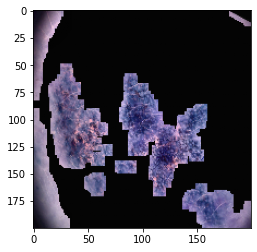

In [52]:
plt.imshow(x_0[0])

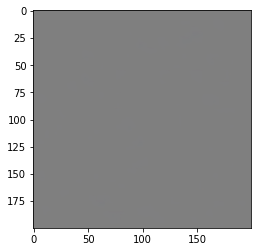

In [53]:
plt.imshow(x_treino_cod[0])

# rede primaria

In [60]:
cnn_i, cnn_j, cnn_chnls = 200, 200, 3

cnn = Sequential()
cnn.add(Conv2D(50, (3, 3), input_shape = (cnn_i, cnn_j, cnn_chnls), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(MaxPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(AvgPool2D((2, 2)))
cnn.add(Flatten())
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(1, activation = 'relu'))
        
cnn.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 0.001))

es = EarlyStopping(monitor = 'loss', patience = 5) 

In [61]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 198, 198, 50)      1400      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 196, 196, 50)      22550     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 98, 98, 50)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 96, 96, 50)        22550     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 94, 94, 50)        22550     
_________________________________________________________________
average_pooling2d_4 (Average (None, 47, 47, 50)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 45, 45, 50)       

In [62]:
batch_size = 100

# Rede com o encoder

In [63]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

cnn.fit(x_treino_cod, y_0, 
             epochs = 100,
             validation_data = (x_valid_cod, y_valid),
             callbacks = [es])

Epoch 1/100
19/19 [==============================] - 17s 881ms/step - loss: 8.7156 - val_loss: 6.1186
Epoch 2/100
19/19 [==============================] - 4s 217ms/step - loss: 6.5014 - val_loss: 5.4655
Epoch 3/100
19/19 [==============================] - 4s 216ms/step - loss: 5.4393 - val_loss: 4.6267
Epoch 4/100
19/19 [==============================] - 4s 217ms/step - loss: 4.2179 - val_loss: 3.6853
Epoch 5/100
19/19 [==============================] - 4s 218ms/step - loss: 3.6157 - val_loss: 3.2847
Epoch 6/100
19/19 [==============================] - 4s 218ms/step - loss: 3.5522 - val_loss: 3.2406
Epoch 7/100
19/19 [==============================] - 4s 218ms/step - loss: 3.1448 - val_loss: 3.1625
Epoch 8/100
19/19 [==============================] - 4s 220ms/step - loss: 2.7968 - val_loss: 2.7948
Epoch 9/100
19/19 [==============================] - 4s 223ms/step - loss: 2.5487 - val_loss: 6.0915
Epoch 10/100
19/19 [==============================] - 4s 223ms/step - loss: 2.2393 - val_l

In [64]:
y_treino_pred = cnn.predict(x_treino_cod)

In [65]:
roc_auc_score(y_0, y_treino_pred)

0.5201512725666648

# Rede sem o encoder

In [66]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

cnn.fit(x_0, y_0, 
             epochs = 100,
             validation_data = (x_valid, y_valid),
             callbacks = [es])

Epoch 1/100
19/19 [==============================] - 4s 226ms/step - loss: 1.5353 - val_loss: 8.0767
Epoch 2/100
19/19 [==============================] - 4s 219ms/step - loss: 1.2717 - val_loss: 8.0692
Epoch 3/100
19/19 [==============================] - 4s 221ms/step - loss: 1.1463 - val_loss: 8.0510
Epoch 4/100
19/19 [==============================] - 4s 219ms/step - loss: 1.1439 - val_loss: 7.9866
Epoch 5/100
19/19 [==============================] - 4s 220ms/step - loss: 1.0949 - val_loss: 7.9462
Epoch 6/100
19/19 [==============================] - 4s 220ms/step - loss: 1.0311 - val_loss: 7.9798
Epoch 7/100
19/19 [==============================] - 4s 220ms/step - loss: 1.0596 - val_loss: 7.9530
Epoch 8/100
19/19 [==============================] - 4s 222ms/step - loss: 0.9717 - val_loss: 7.9573
Epoch 9/100
19/19 [==============================] - 4s 223ms/step - loss: 0.9528 - val_loss: 7.9324
Epoch 10/100
19/19 [==============================] - 4s 223ms/step - loss: 1.0019 - val_lo

In [67]:
y_treino_pred = cnn.predict(x_0)

In [68]:
roc_auc_score(y_0, y_treino_pred)

0.9174957213051399

# Complexificando a rede

In [134]:
cnn_i, cnn_j, cnn_chnls = 200, 200, 3

cnn = Sequential()
cnn.add(Conv2D(100, (3, 3), input_shape = (cnn_i, cnn_j, cnn_chnls), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(MaxPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(100, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(AvgPool2D((2, 2)))
cnn.add(Flatten())
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(150, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(150, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(100, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(1, activation = 'relu'))
        
cnn.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 0.001))

es = EarlyStopping(monitor = 'loss', patience = 5) 

In [135]:
cnn.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 198, 198, 100)     2800      
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 196, 196, 50)      45050     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 98, 98, 50)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 96, 96, 50)        22550     
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 94, 94, 50)        22550     
_________________________________________________________________
average_pooling2d_37 (Averag (None, 47, 47, 50)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 45, 45, 100)     

In [136]:
batch_size = 100

In [137]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

cnn.fit(x_0, y_0, 
             epochs = 100,
             validation_data = (x_valid, y_valid),
             callbacks = [es])

Epoch 1/100
19/19 [==============================] - 9s 480ms/step - loss: 20.3501 - val_loss: 22.7647
Epoch 2/100
19/19 [==============================] - 6s 342ms/step - loss: 18.4285 - val_loss: 21.6963
Epoch 3/100
19/19 [==============================] - 6s 333ms/step - loss: 16.5368 - val_loss: 20.7635
Epoch 4/100
19/19 [==============================] - 6s 334ms/step - loss: 14.5182 - val_loss: 19.9379
Epoch 5/100
19/19 [==============================] - 6s 335ms/step - loss: 13.7060 - val_loss: 18.8301
Epoch 6/100
19/19 [==============================] - 6s 335ms/step - loss: 12.9058 - val_loss: 17.9566
Epoch 7/100
19/19 [==============================] - 6s 335ms/step - loss: 11.8960 - val_loss: 17.1615
Epoch 8/100
19/19 [==============================] - 6s 338ms/step - loss: 10.3444 - val_loss: 15.9758
Epoch 9/100
19/19 [==============================] - 6s 339ms/step - loss: 9.3013 - val_loss: 14.9245
Epoch 10/100
19/19 [==============================] - 7s 343ms/step - loss

In [138]:
y_treino_pred = cnn.predict(x_0)

In [139]:
roc_auc_score(y_0, y_treino_pred)

0.40209241980897703

# Terceira rede

In [169]:
cnn_i, cnn_j, cnn_chnls = 200, 200, 3

cnn = Sequential()
cnn.add(Conv2D(50, (3, 3), input_shape = (cnn_i, cnn_j, cnn_chnls), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(MaxPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Flatten())
cnn.add(Dense(10, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(100, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(200, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(250, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(100, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(1, activation = 'relu'))
        
cnn.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 0.001))


In [170]:
cnn.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_167 (Conv2D)          (None, 198, 198, 50)      1400      
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 196, 196, 50)      22550     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 98, 98, 50)        0         
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 96, 96, 50)        22550     
_________________________________________________________________
average_pooling2d_51 (Averag (None, 48, 48, 50)        0         
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 46, 46, 50)        22550     
_________________________________________________________________
batch_normalization_71 (Batc (None, 46, 46, 50)      

In [171]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

cnn.fit(x_0, y_0, 
             epochs = 100,
             validation_data = (x_valid, y_valid),
             callbacks = [es])

Epoch 1/100
19/19 [==============================] - 21s 1s/step - loss: 32.8765 - val_loss: 34.0730
Epoch 2/100
19/19 [==============================] - 4s 206ms/step - loss: 30.2349 - val_loss: 32.5244
Epoch 3/100
19/19 [==============================] - 4s 207ms/step - loss: 28.4173 - val_loss: 31.3412
Epoch 4/100
19/19 [==============================] - 4s 207ms/step - loss: 27.4207 - val_loss: 30.1932
Epoch 5/100
19/19 [==============================] - 4s 207ms/step - loss: 25.4209 - val_loss: 29.0705
Epoch 6/100
19/19 [==============================] - 4s 208ms/step - loss: 23.7366 - val_loss: 27.8052
Epoch 7/100
19/19 [==============================] - 4s 208ms/step - loss: 22.5802 - val_loss: 26.3523
Epoch 8/100
19/19 [==============================] - 4s 210ms/step - loss: 20.5635 - val_loss: 24.6608
Epoch 9/100
19/19 [==============================] - 4s 212ms/step - loss: 18.5286 - val_loss: 23.0884
Epoch 10/100
19/19 [==============================] - 4s 212ms/step - loss:

In [172]:
y_treino_pred = cnn.predict(x_0)

In [173]:
roc_auc_score(y_0, y_treino_pred)

0.6102136586981726